# Introduction

In [3]:
import inspect
import math
import os
import time

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
# gui
import qgrid
import seaborn as sns
# pyro & pytorch
import torch
import torch.distributions.constraints as constraints
from ipywidgets import fixed, interact
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam
# loading & saving data
from scipy.io import loadmat
from sklearn.metrics import matthews_corrcoef
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from glimpse_read import AoIDataset, GlimpseDataset
from noise import (GammaNoise, GammaNoiseNoOffset, NormalNoise,
                   PoissonNoise)
from spot import GaussianSpot
from utils import (get_offset, load_obj, save_obj, view_aoi,
                   view_aoi_class_average, view_aoi_class_summary,
                   view_aoi_summary, view_glimpse, write_summary)

%matplotlib inline
qgrid.enable()
pyro.enable_validation(True)

%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams["font.size"] = 16
plt.rcParams["font.size"]

16.0

In [5]:
#device = torch.device("cuda:0")
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
#torch.cuda.is_available()

# Load Data

## Load header

In [6]:
# load header file (.mat format)
path_header = "/home/ordabayev/Documents/postdoc/Bayesian_noise_files/yhili2000006_conti_exp_lane2"
mat_header = loadmat(os.path.join(path_header, "header.mat"))

# convert header into dict format
header = dict()
for i, dt in  enumerate(mat_header["vid"].dtype.names):
    header[dt] = np.squeeze(mat_header["vid"][0,0][i])

# display header dictionary keys
header.keys()

dict_keys(['moviefile', 'username', 'description', 'nframes', 'time1', 'ttb', 'depth', 'offset', 'filenumber', 'width', 'height', 'camera', 'microscope', 'mversion', 'laser_names', 'filter_names', 'lasers', 'filters', 'flowrate', 'temp', 'field', 'header2', 'stagexyz'])

## Load aoiinfo and driftlist

In [7]:
path = "/home/ordabayev/Documents/postdoc/Bayesian_noise_files"
aoi_filename = "b35p90f.dat"
drift_filename = "yhili2000006_cy5_driftlist.dat"

In [8]:
# load aoiinfo mat file
aoi_mat = loadmat(os.path.join(path, aoi_filename))
# convert aoiinfo into DataFrame
aoi_df = pd.DataFrame(aoi_mat["aoiinfo2"], columns=["frame", "ave", "x", "y", "pixnum", "aoi"])
aoi_df = aoi_df.astype({"aoi": int}).set_index("aoi")
aoi_df.head(6)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [9]:
# load driftlist mat file
drift_mat = loadmat(os.path.join(path, drift_filename))
# calculate the cumulative sum of dx and dy
drift_mat["driftlist"][:, 1:3] = np.cumsum(
    drift_mat["driftlist"][:, 1:3], axis=0)
# convert driftlist into DataFrame
drift_df = pd.DataFrame(drift_mat["driftlist"], columns=[
                        "frame", "dx", "dy", "timestamp"])
drift_df = drift_df.astype({"frame": int}).set_index("frame")
#drift_df.head(6)

## Load AoI
AoIDataset is a class that loads batch of aoi frames on demand from the disk.  My tests show that it is fast enough to not be rate limiting during model training.
TODO: Add feature to load multiple aois.

In [10]:
glimpse_data = GlimpseDataset(D=10, aoi_df=aoi_df, drift_df=drift_df, header=header, path=path_header)

#data.info

100%|██████████| 2366/2366 [00:19<00:00, 121.17it/s]


In [11]:
data, _ = glimpse_data[22]

In [12]:
labels = pd.read_csv("aoi22_labels.csv", names=["frame", "labels"])
labels = labels.astype({"frame": int}).set_index("frame")
data.info["labels"] = labels["labels"]
data.info = data.info.astype({"labels": int})

data.info

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

# Visualize Data

## View glimpse images

In [21]:
aoi_list = aoi_df.index
frame_list = drift_df.index

interact(view_glimpse, frame=frame_list, aoi=aoi_list,
         aoi_df=fixed(aoi_df.loc[aoi_list]), drift_df=fixed(drift_df.loc[frame_list]), 
         header=fixed(header), path_glimpse=fixed(path_header),
         selected_aoi=True, all_aois=True, offset=False)

interactive(children=(Dropdown(description='frame', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15…

<function utils.view_glimpse(frame, aoi, aoi_df, drift_df, header, path_glimpse, selected_aoi, all_aois, offset)>

## View AoI

In [11]:
interact(view_aoi_summary, data=fixed(data))

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<function utils.view_aoi_summary(data)>

In [26]:
frame_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.info.index)])

interact(view_aoi, frame=frame_widget, data=fixed(data), show_class=False)

interactive(children=(Dropdown(description='frame', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (…

<function utils.view_aoi(frame, data, show_class=False)>

## View offset
TODO: Use EmpiricalDistribution for the offset. Therefore the overall camera signal will be the sum of two random variables = offset(empirical) + signal(gamma).
TODO2: Look pixel by pixel

In [24]:
offset = get_offset(drift_df.index, header, path_header)
samples, counts = np.unique(offset, return_counts=True)

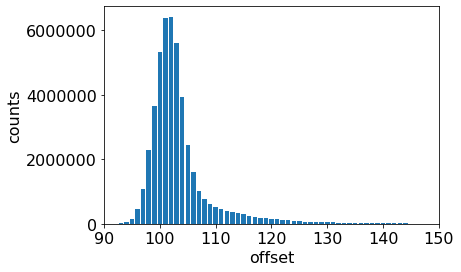

In [52]:
plt.bar(samples, counts)
plt.ylabel("counts")
plt.xlabel("offset")
plt.xlim(90,150)
plt.show()

In [54]:
save_offset = np.zeros((len(samples),2))
save_offset[:,0] = samples
save_offset[:,1] = counts
np.savetxt("offset.csv", save_offset, delimiter=",")

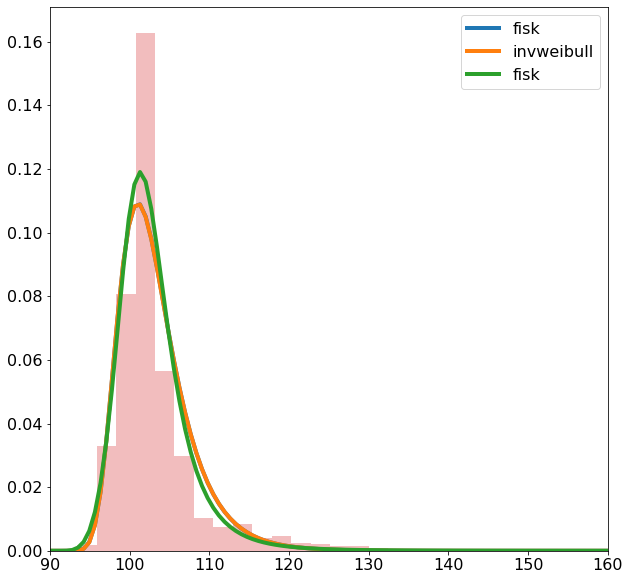

In [106]:
plt.figure(figsize=(10,10))
plt.plot(x, burr.pdf(x, *pars_burr), lw=4, label="fisk")
plt.plot(x, invweibull.pdf(x, *pars_weibull), lw=4, label="invweibull")

#pars = fisk.fit(off)
plt.plot(x, fisk.pdf(x, *pars), lw=4, label="fisk")

plt.hist(off, bins=50, density=True, alpha=0.3)
plt.xlim(90,160)
plt.legend()
plt.show()

# Feature extraction

## Fit local height, x, and y parameter

In [9]:
# gaussian spot model + gamma noise model
model = type("GaussianGamma", (GaussianSpot,GammaNoise),dict())

gaussgamma = model(data)

In [10]:
pyro.clear_param_store()

#batch_size = 256

def per_param_callable(module_name, param_name):
    if param_name in ["offset_delta", "auto_height"]:
        return {"lr": 0.2, 'betas': [0.9, 0.999]}
    else:
        return {"lr": 0.05, 'betas': [0.9, 0.999]}
#optim = pyro.optim.ASGD({"lr":0.1})
optim = pyro.optim.Adam(per_param_callable)
elbo = Trace_ELBO()
svi = SVI(gaussgamma.feature_model, gaussgamma.feature_guide, optim, loss=elbo)

In [11]:
history = {}
history["code"] = inspect.getsource(GammaNoise)
history["info"] = data.info

In [12]:
local_data = gaussgamma.data[:]

In [18]:
max_epochs = 150

for i in tqdm(range(max_epochs)):
    loss = svi.step(local_data)
    history.setdefault("losses", []).append(loss)
    for p in pyro.get_param_store().get_all_param_names():
        try:
            history.setdefault(p, []).append(pyro.param(p).item())
        except ValueError:
            history.setdefault(p, []).append(pyro.param(p).tolist())
    #print("" if i % int(n_steps/100) else ".", end="")
    
save_obj(history, os.path.join(path, "checkpoints", "last.pkl"))

100%|██████████| 400/400 [02:38<00:00,  3.63it/s]


In [3]:
pyro.param("auto_height")

KeyError: 'auto_height'

In [19]:
dset = pd.DataFrame(data={"height": pyro.param("auto_height").cpu().detach(),
                          "x0": pyro.param("auto_x0").cpu().detach(), "y0": pyro.param("auto_y0").cpu().detach()})

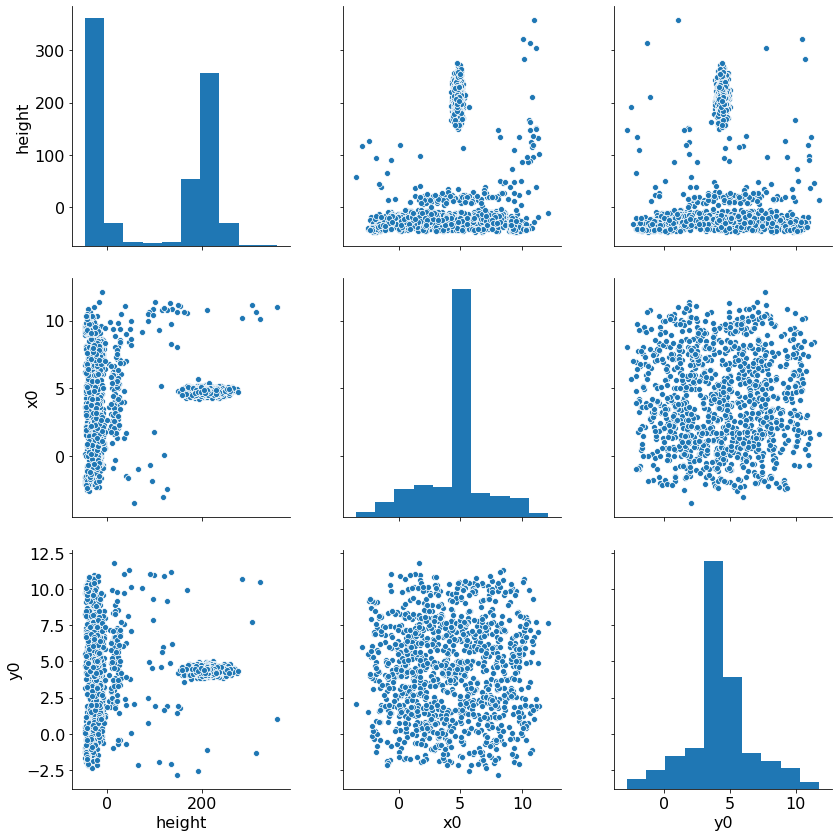

In [20]:
sns.pairplot(dset, vars=dset.columns, height=4)
plt.show()

In [21]:
interact(view_history, filename=[file for file in os.listdir(os.path.join(path, "checkpoints")) if file.endswith(".pkl")],
        path=fixed(path))

interactive(children=(Dropdown(description='filename', options=('last.pkl',), value='last.pkl'), Output()), _d…

<function utils.view_history(filename, path)>

## Determine the number of states

In [34]:
data = torch.tensor(dset.values)

In [35]:
K = 2  # Fixed number of components.

pyro.clear_param_store()

@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample("weights", dist.Dirichlet(0.5 * torch.ones(K)))
    with pyro.plate("components", K):
        locs = pyro.sample("locs", 
                dist.Normal(torch.tensor([0., 4.5, 4.5]), torch.tensor([500., 100., 100.])).to_event(1))
        scale = pyro.sample("scale", 
                dist.LogNormal(torch.tensor([0., 0., 0.]), torch.tensor([2., 2., 2.])).to_event(1))

    with pyro.plate("data", len(data)):
        # Local variables.
        z = pyro.sample("z", dist.Categorical(weights))
        #print(locs.shape, locs[z].shape, data.shape)
        pyro.sample("obs", dist.Normal(locs[z], scale[z]).to_event(1), obs=data)

@config_enumerate
def full_guide(data):
    # Global variables.
    auto_weights = pyro.param("auto_weights", torch.ones(K) / K, constraint=constraints.simplex)
    pyro.sample("weights", dist.Delta(auto_weights).to_event(1))
    # Assume half of the data variance is due to intra-component noise.
    auto_scale = pyro.param("auto_scale", torch.ones(K,3), 
                            constraint=constraints.positive)
    auto_locs = pyro.param("auto_locs", torch.ones(K,3), 
                           constraint=constraints.positive)
    with pyro.plate("components", K):
        pyro.sample("locs", dist.Delta(auto_locs).to_event(1))
        pyro.sample("scale", dist.Delta(auto_scale).to_event(1))
    # Local variables.
    z_probs = pyro.param("z_probs", torch.ones(len(data), K) / K, constraint=constraints.simplex)
    with pyro.plate("data", len(data)):
        pyro.sample("z", dist.Categorical(z_probs))

In [36]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO()
svi = SVI(model, full_guide, optim, loss=elbo)

In [37]:
data[torch.multinomial(torch.ones(len(data)) / len(data), K)]

tensor([[ 2.2511e+02,  4.4049e+00,  3.8472e+00],
        [-2.4001e+01,  2.0852e-01,  4.8947e+00]])

In [38]:
torch.multinomial(torch.ones(len(data)) / len(data), K)

tensor([966, 849])

In [39]:
torch.ones(len(data)) / len(data)

tensor([0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004])

In [494]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init="random", n_init=100, random_state=0).fit(data)

In [ ]:
pyro.clear_param_store()
# Initialize weights to uniform.
pyro.param("auto_weights", torch.tensor([(kmeans.labels_ == k).mean() for k in range(K)]), constraint=constraints.simplex)
# Assume half of the data variance is due to intra-component noise.
pyro.param("auto_scale", ((data.var(dim=0) / 2).sqrt()).expand(K,3), constraint=constraints.positive)
# Initialize means from a subsample of data.
pyro.param("auto_locs", data[torch.multinomial(torch.ones(len(data)) / len(data), K)])

In [533]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)
    # Assume half of the data variance is due to intra-component noise.
    pyro.param('auto_scale', ((data.var(dim=0) / 2).sqrt()).expand(K,3), constraint=constraints.positive)
    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)])
    loss = svi.loss(model, full_guide, data)
    return loss

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 3, initial_loss = 26936.888671875


In [534]:
pyro.param("auto_locs")

tensor([[165.5023,   4.2665,   4.1720],
        [177.5213,   4.9989,   4.5666]], requires_grad=True)

In [535]:
history = {}

In [536]:
n_steps = 1000
for i in range(n_steps):
    loss = svi.step(data)
    history.setdefault("losses", []).append(loss)
    for p in pyro.get_param_store().get_all_param_names():
        try:
            history.setdefault(p, []).append(pyro.param(p).item())
        except ValueError:
            history.setdefault(p, []).append(pyro.param(p).tolist())
    print("" if i % int(n_steps/100) else ".", end="")
    
save_obj(history, os.path.join(path, "checkpoints", "last.pkl"))

....................................................................................................

In [446]:
interact(view_history, filename=[file for file in os.listdir(os.path.join(path, "checkpoints")) if file.endswith(".pkl")],
        path=fixed(path))

interactive(children=(Dropdown(description='filename', options=('last.pkl',), value='last.pkl'), Output()), _d…

<function utils.view_history(filename, path)>

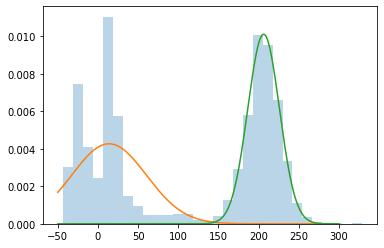

In [448]:
X = torch.arange(-50,300,0.1)
posterior = dist.Normal(pyro.param("auto_locs")[0,0], pyro.param("auto_scale")[0,0])
Y1 = torch.exp(posterior.log_prob(X))
posterior = dist.Normal(pyro.param("auto_locs")[1,0], pyro.param("auto_scale")[1,0])
#posterior = dist.Gamma(60, 0.3)
Y2 = torch.exp(posterior.log_prob(X))
#posterior = dist.Normal(pyro.param("auto_locs")[2,0], pyro.param("auto_scale")[2,0])
#Y3 = torch.exp(posterior.log_prob(X))

plt.hist(data[:,0], bins=30, density=True, alpha=0.3)
plt.plot(X.cpu().numpy(), Y1.data.cpu().numpy()*pyro.param("auto_weights")[0].item(), label="0")
plt.plot(X.cpu().numpy(), Y2.data.cpu().numpy()*pyro.param("auto_weights")[1].item(), label="1")
#plt.plot(X.cpu().numpy(), Y3.data.cpu().numpy()*pyro.param("auto_weights")[2].item(), label="2")
#plt.ylim(0,0.001)
plt.show()

In [537]:
dset["cat"] = pyro.param("z_probs").detach().max(dim=1).indices

In [553]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data)
kmeans_data = scaler.transform(data)


In [557]:
kmeans = KMeans(n_clusters=4, init="random", n_init=100, random_state=0).fit(kmeans_data)
dset["label"] = kmeans.labels_

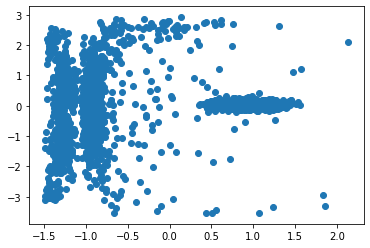

In [559]:
plt.scatter(kmeans_data[:,0], kmeans_data[:,1])
plt.show()

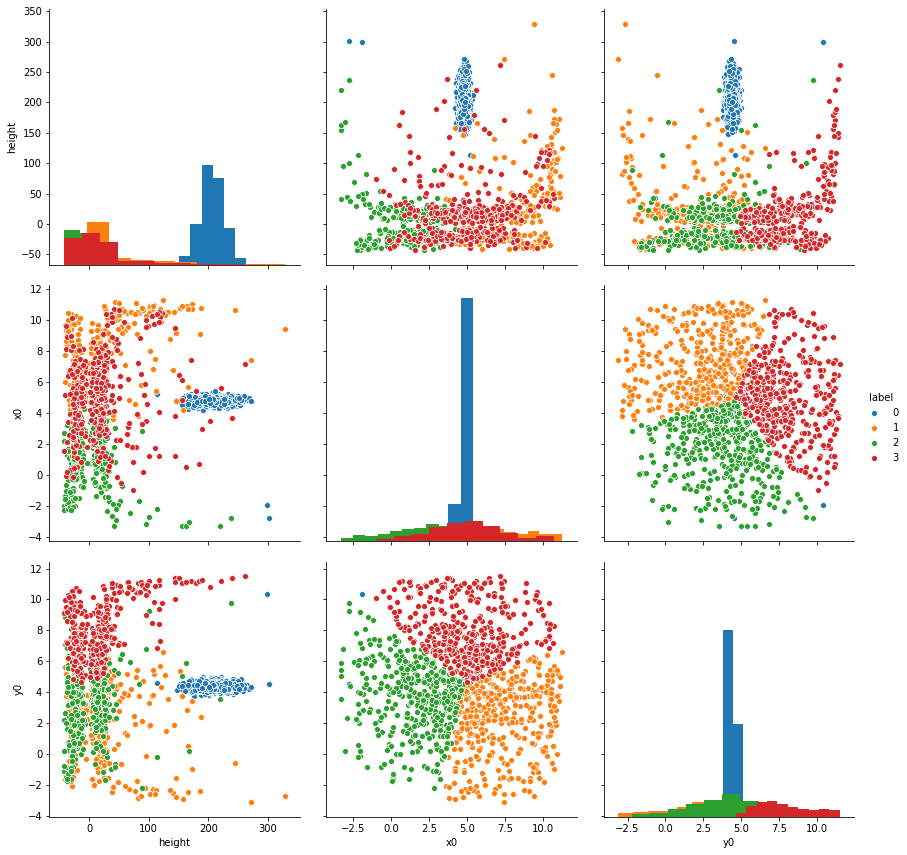

In [558]:
sns.pairplot(dset, vars=["height", "x0", "y0"], diag_kind="hist", hue="label", height=4)
plt.show()

In [55]:
pyro.param("height_loc", pyro.param("auto_locs")[1:].detach(), constraint=constraints.positive)
pyro.param("width_delta", torch.ones(gmm.K-1)*pyro.param("auto_width").item(), constraint=constraints.positive)
pyro.param("x_delta", pyro.param("auto_x_locs")[1:].detach(), constraint=constraints.interval(0, 10))
pyro.param("y_delta", pyro.param("auto_y_locs")[1:].detach(), constraint=constraints.interval(0, 10))

tensor([4.3926], grad_fn=<AddBackward0>)

# Fitting & Classification

## Initiate models

In [13]:
models = {}
spot_models = {}
noise_models = {}
writers = {}

### GammaOffset

In [14]:
# init
model_name = "GammaOffset"
# gaussian spot model + gamma noise model
spot_models[model_name] = GaussianSpot
noise_models[model_name] = GammaNoise

Model = type(model_name, (spot_models[model_name],noise_models[model_name]),{}) # change here

models[model_name] = Model(data, K=2) # change here

writers[model_name] = SummaryWriter(log_dir=os.path.join(path,"runs/aoi{}/{}/K{}".format(
    data.aoi, models[model_name].__class__.__name__, models[model_name].K)))

### Gamma

In [19]:
# init
model_name = "GaussianGammaNoOffset"
# gaussian spot model + gamma noise model
spot_models[model_name] = GaussianSpot
noise_models[model_name] = GammaNoiseNoOffset

Model = type(model_name, (spot_models[model_name],noise_models[model_name]),{}) # change here

models[model_name] = Model(data, K=2) # change here

writers[model_name] = SummaryWriter(log_dir=os.path.join(path,"runs/aoi{}/{}/K{}".format(
    models[model_name].data.aoi, models[model_name].__class__.__name__, models[model_name].K)))

### Normal

In [12]:
# init
model_name = "GaussianNormal"
# gaussian spot model + gamma noise model
spot_models[model_name] = GaussianSpot
noise_models[model_name] = NormalNoise

Model = type(model_name, (spot_models[model_name],noise_models[model_name]),{}) # change here

models[model_name] = Model(data, K=2) # change here

writers[model_name] = SummaryWriter(log_dir=os.path.join(path,"runs/aoi{}/{}/K{}".format(
    models[model_name].data.aoi, models[model_name].__class__.__name__, models[model_name].K)))

### Poisson

In [12]:
# init
model_name = "GaussianPoisson"
# gaussian spot model + gamma noise model
spot_models[model_name] = GaussianSpot
noise_models[model_name] = PoissonNoise

Model = type(model_name, (spot_models[model_name],noise_models[model_name]),{}) # change here

models[model_name] = Model(data, K=2) # change here

writers[model_name] = SummaryWriter(log_dir=os.path.join(path,"runs/aoi{}/{}/K{}".format(
    models[model_name].data.aoi, models[model_name].__class__.__name__, models[model_name].K)))

##  Choose the model

### GaussianGamma

In [15]:
model_name = "GammaOffset"

model = models[model_name]
writer = writers[model_name]

### GaussianGammaNoOffset

In [20]:
# switch
model_name = "GaussianGammaNoOffset"

model = models[model_name]
writer = writers[model_name]

### GaussianNormal

In [37]:
# switch
model_name = "GaussianNormal"

model = models[model_name]
writer = writers[model_name]

### GaussianPoisson

In [13]:
# switch
model_name = "GaussianPoisson"

model = models[model_name]
writer = writers[model_name]

### PoissonGain

In [21]:
# switch
model_name = "Poisson"

model = models[model_name]
writer = writers[model_name]

## Train the model

In [16]:
pyro.clear_param_store()

optim = pyro.optim.Adam({"lr": 0.1, "betas": [0.9, 0.999]})
elbo = TraceEnum_ELBO()
#elbo = Trace_ELBO()
svi = SVI(model.mixture_model, model.mixture_guide, optim, loss=elbo)


writer.add_text("Spot Model", inspect.getsource(spot_models[model_name])) # change here
writer.add_text("Noise Model", inspect.getsource(noise_models[model_name])) # change here

epoch_count = 0
batch_size = 256
write_summary(epoch_count, batch_size, model, svi, writer, feature=False, mcc=False)

In [17]:
n_epochs = 100

for epoch in tqdm(range(n_epochs)):
    # Training
    for batch_sample, batch_idx in DataLoader(model.data, batch_size=256, shuffle=True):
        # Transfer to GPU
        # batch_sample = batch_sample.to(device)#, batch_idx.to(device)
        loss = svi.step(batch_sample, batch_idx)
        
    write_summary(epoch_count, batch_size, model, svi, writer, feature=False, mcc=True)
    epoch_count += 1

100%|██████████| 100/100 [01:11<00:00,  1.25it/s]


### Simulations

In [17]:
sample_data = model.sample()

In [18]:
for k in range(model.K):
    writer.add_histogram("hist_class_{}".format(k), model.data[torch.tensor(
        (model.data.info["predictions"] == k).values)].reshape(-1).cpu(), 0)
    writer.add_histogram("hist_class_{}".format(k), sample_data[torch.tensor(
        (model.data.info["predictions"] == k).values)].reshape(-1).cpu(), 1)
    
    #for i in range(model.D**2):
    #    x, y = divmod(i, model.D)
    #    writer.add_histogram("pixel_{}_{}_class_{}".format(x,y,k), model.data[torch.tensor((model.data.info["predictions"] == k).values)]
    #     [:, x, y], 0)
    #    writer.add_histogram("pixel_{}_{}_class_{}".format(x,y,k), sample_data[torch.tensor((model.data.info["predictions"] == k).values)]
    #     [:, x, y], 1)

### Classification

In [16]:
for i in range(model.K):
    model.data.info["z_{}".format(i)] = pyro.param("z_probs")[:,i].detach()
# class based on the highest probability
model.data.info["predictions"] = pyro.param("z_probs").detach().argmax(dim=1)
model.data.info.head(6)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [31]:
#data.info["z"].to_csv("aoi22_labels.csv", header=False)

In [19]:
frame_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(model.data.info.index)])

interact(view_aoi, frame=frame_widget, data=fixed(model.data), show_class=True)

interactive(children=(Dropdown(description='frame', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (…

<function utils.view_aoi(frame, data, show_class=False)>

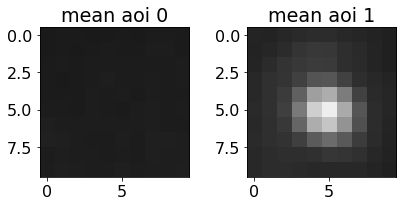

In [20]:
view_aoi_class_average(model.data, model.K)

# Fitting results

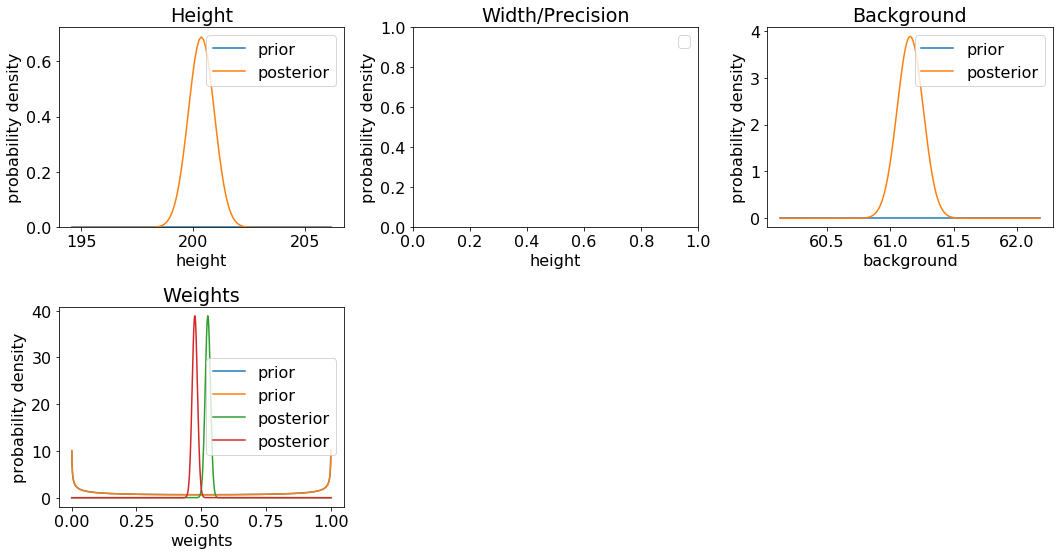

In [67]:
plt.figure(figsize=(15,8))

X = torch.arange(pyro.param("height_loc").item()-pyro.param("height_scale").item()*10, pyro.param("height_loc").item()+pyro.param("height_scale").item()*10,0.1)
#X = torch.arange(190,240,0.1)
prior = dist.HalfNormal(500.)
posterior = dist.Normal(pyro.param("height_loc"), pyro.param("height_scale"))
Y_prior = torch.exp(prior.log_prob(X))
Y_posterior = torch.exp(posterior.log_prob(X))

plt.subplot(2,3,1)
plt.plot(X.cpu().numpy(), Y_prior.data.cpu().numpy(), label="prior")
plt.plot(X.cpu().numpy(), Y_posterior.data.cpu().numpy(), label="posterior")
#plt.plot([h_true, h_true], [0., Y_posterior.max().item()], 'k--', label="true")
plt.title("Height")
plt.ylabel("probability density")
plt.xlabel("height")
plt.ylim(0,)
plt.legend()


X = torch.arange(0.5,2.,0.01)
prior = dist.Gamma(1., 0.1)
#posterior = dist.Gamma(pyro.param("width_alpha"), pyro.param("width_beta"))
Y_prior = torch.exp(prior.log_prob(X))
Y_posterior = torch.exp(posterior.log_prob(X))

plt.subplot(2,3,2)
plt.title("Width/Precision")
plt.ylabel("probability density")
plt.xlabel("height")
plt.legend()


X = torch.arange(pyro.param("background_loc").item()-pyro.param("background_scale").item()*10, pyro.param("background_loc").item()+pyro.param("background_scale").item()*10,0.01)
prior = dist.HalfNormal(1000.)
posterior = dist.Normal(pyro.param("background_loc"), pyro.param("background_scale"))
Y_prior = torch.exp(prior.log_prob(X))
Y_posterior = torch.exp(posterior.log_prob(X))

plt.subplot(2,3,3)
plt.plot(X.cpu().numpy(), Y_prior.data.cpu().numpy(), label="prior")
plt.plot(X.cpu().numpy(), Y_posterior.data.cpu().numpy(), label="posterior")
#plt.plot([b_true, b_true], [0., Y_posterior.max().item()], 'k--', label="true")
plt.title("Background")
plt.ylabel("probability density")
plt.xlabel("background")
plt.legend()

X = torch.stack((torch.arange(0,1,0.001), torch.arange(1,0,-0.001)), dim=1)
prior = dist.Dirichlet(0.5 * torch.ones(2))
posterior = dist.Dirichlet(pyro.param("weights_conc"))
Y_prior = torch.exp(prior.log_prob(X))
Y_posterior = torch.exp(posterior.log_prob(X))

plt.subplot(2,3,4)
plt.plot(X.cpu().numpy(), Y_prior.data.cpu().numpy(), label="prior")
plt.plot(X.cpu().numpy(), Y_posterior.data.cpu().numpy(), label="posterior")
#plt.plot([pi_true[0], pi_true[0]], [0., Y_posterior.max().item()], 'k--')
#plt.plot([pi_true[1], pi_true[1]], [0., Y_posterior.max().item()], 'k--')
plt.title("Weights")
plt.ylabel("probability density")
plt.xlabel("weights")
plt.legend()




plt.tight_layout()
plt.show()

In [ ]:


def per_param_callable(module_name, param_name):
    if param_name in ["background_loc", "background_scale", "height_scale", "height_loc"]:
        return {"lr": 0.2, 'betas': [0.9, 0.999]}
    else:
        return {"lr": 0.05, 'betas': [0.9, 0.999]}
#optim = pyro.optim.ASGD({"lr":0.1})

In [ ]:
#trace = poutine.trace(gaussgamma.mixture_model).get_trace(gaussgamma.data[:], torch.arange(len(gaussgamma.data)))
#trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
#print(trace.format_shapes())

In [ ]:
# load checkpoint
optim.load("checkpoints/gmm_aoi17_optim_2019-06-24_10:01:04.ckpt")
pyro.get_param_store().load("checkpoints/gmm_aoi17_param_2019-06-24_10:01:04.ckpt")
history = load_obj("checkpoints/gmm_aoi17_history_2019-06-24_10:01:04.pkl")

In [ ]:
# save checkpoint
st = datetime.datetime.fromtimestamp(end).strftime('%Y-%m-%d_%H:%M:%S')
optim.save("checkpoints/{}_aoi{}_optim_{}.ckpt".format(gmm.name, aoi, st))
pyro.get_param_store().save("checkpoints/{}_aoi{}_param_{}.ckpt".format(gmm.name, aoi, st))
save_obj(history, "checkpoints/{}_aoi{}_history_{}.pkl".format(gmm.name, aoi, st))